In [9]:
import pandas as pd

In [10]:
ratings = pd.read_csv(r'ratings_small_filtered_2.csv', index_col=0)

In [11]:
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1061,3.0,1260759182
2,1,1129,2.0,1260759185
3,1,1172,4.0,1260759205
4,1,1263,2.0,1260759151
...,...,...,...,...
81725,671,6212,2.5,1065149436
81726,671,6268,2.5,1065579370
81727,671,6365,4.0,1070940363
81728,671,6385,2.5,1070979663


In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81730 entries, 0 to 81729
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     81730 non-null  int64  
 1   movieId    81730 non-null  int64  
 2   rating     81730 non-null  float64
 3   timestamp  81730 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
ratings['rating'] = ratings['rating'].apply(lambda x: 1 if x > 3.5 else 0)


In [14]:
ratings

,userId,movieId,rating,timestamp
0,1,31,0,1260759144
1,1,1061,0,1260759182
2,1,1129,0,1260759185
3,1,1172,1,1260759205
4,1,1263,0,1260759151
...,...,...,...,...
81725,671,6212,0,1065149436
81726,671,6268,0,1065579370
81727,671,6365,1,1070940363
81728,671,6385,0,1070979663


In [15]:
value_counts = ratings['rating'].value_counts()
value_counts

rating
1    42496
0    39234
Name: count, dtype: int64

In [16]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from collections import Counter

# Assuming ratings DataFrame is already loaded
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Fill NaN with a distinct value (e.g., -1) to differentiate from actual ratings
item_user_matrix_filled = user_item_matrix.T.fillna(0.5)

# Compute cosine similarity
item_similarity = cosine_similarity(item_user_matrix_filled)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Create training and testing sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

def get_k_nearest_neighbors(item_similarity_df, movie_id, k=10):
    # Get the similarity scores for the movie with all other movies
    sim_scores = item_similarity_df[movie_id]
    # Sort the movies by similarity score in descending order and select the top k
    nearest_neighbors = sim_scores.sort_values(ascending=False).index[1:k+1]
    return nearest_neighbors

def predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=10):
    # Get k nearest neighbors
    nearest_neighbors = get_k_nearest_neighbors(item_similarity_df, movie_id, k)
    
    # Get the ratings of the user for the nearest neighbors
    neighbor_ratings = user_item_matrix.loc[user_id, nearest_neighbors]
    
    # If there are no ratings by nearest neighbors, return 0
    if neighbor_ratings.isna().all():
        return 0
    
    # Predict the rating based on the majority vote of neighbor ratings
    return Counter(neighbor_ratings.dropna()).most_common(1)[0][0]

# Predict ratings for all users and movies in the test set
y_true_all = []
y_pred_all = []

for index, row in test_ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    y_true_all.append(row['rating'])
    y_pred_all.append(predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=255))

# Convert to integers
y_true_all = [int(val) for val in y_true_all]
y_pred_all = [int(val) for val in y_pred_all]

# Generate classification report
print(classification_report(y_true_all, y_pred_all))


In [17]:
All_parts_objects = pd.read_csv(r'All_parts_objects.csv', index_col=2)
columns_to_keep = [str(i) for i in range(80)]
movies_features = All_parts_objects[columns_to_keep]
movies_features

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
movieId,,,,,,,,,,,,,,,,,,,,,
1,194,0,1,1,3,0,0,1,0,0,...,0,0,1,33,0,1,0,5,0,1
2,629,0,43,0,3,0,0,5,0,2,...,0,0,0,9,16,14,4,0,0,3
3,709,0,11,0,0,0,0,2,26,0,...,0,0,0,0,0,2,0,0,0,0
4,1141,0,22,0,0,0,0,8,0,1,...,0,0,0,0,2,0,0,0,0,0
6,1049,0,115,0,12,5,1,11,0,9,...,0,0,2,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130682,282,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,1,2,0,0,0
130970,1731,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,402
130980,170,0,2,5,210,0,0,1,101,0,...,0,0,0,1,5,27,0,0,0,0


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming movies_features DataFrame is already loaded
item_metadata_matrix = movies_features

# Fill NaN with a distinct value (e.g., 0) to ensure it doesn't affect similarity
item_metadata_matrix_filled = item_metadata_matrix.fillna(0)

# Compute cosine similarity
item_similarity = cosine_similarity(item_metadata_matrix_filled)
item_similarity_df = pd.DataFrame(item_similarity, index=item_metadata_matrix.index, columns=item_metadata_matrix.index)

# Predict ratings for all users and movies in the test set using item-item similarity
y_true_all = []
y_pred_all = []

for index, row in test_ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    y_true_all.append(row['rating'])
    
    # Get k nearest neighbors based on item-item similarity
    nearest_neighbors = get_k_nearest_neighbors(item_similarity_df, movie_id, k=255)
    
    # Get the ratings of the user for the nearest neighbors
    neighbor_ratings = user_item_matrix.loc[user_id, nearest_neighbors]
    
    # If there are no ratings by nearest neighbors, predict 0
    if neighbor_ratings.isna().all():
        y_pred_all.append(0)
    else:
        # Predict the rating based on the majority vote of neighbor ratings
        y_pred_all.append(Counter(neighbor_ratings.dropna()).most_common(1)[0][0])

# Convert to integers
y_true_all = [int(val) for val in y_true_all]
y_pred_all = [int(val) for val in y_pred_all]

# Generate classification report
print(classification_report(y_true_all, y_pred_all))


              precision    recall  f1-score   support

           0       0.60      0.62      0.61      7794
           1       0.64      0.62      0.63      8552

    accuracy                           0.62     16346
   macro avg       0.62      0.62      0.62     16346
weighted avg       0.62      0.62      0.62     16346



In [19]:
# Apply thresholding to item similarity matrix
threshold = 0.3 # Adjust as needed
item_similarity_df_thresholded = item_similarity_df.applymap(lambda x: x if x > threshold else 0)

# Predict ratings for all users and movies in the test set using item-item similarity
y_true_all = []
y_pred_all = []

# Predict ratings using thresholded similarity matrix
for index, row in test_ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    y_true_all.append(row['rating'])
    # Get k nearest neighbors based on thresholded item-item similarity
    nearest_neighbors = item_similarity_df_thresholded[movie_id].nlargest(255).index
    
    # Get the ratings of the user for the nearest neighbors
    neighbor_ratings = user_item_matrix.loc[user_id, nearest_neighbors]
    
    # If there are no ratings by nearest neighbors, predict 0
    if neighbor_ratings.isna().all():
        y_pred_all.append(0)
    else:
        # Predict the rating based on the majority vote of neighbor ratings
        y_pred_all.append(Counter(neighbor_ratings.dropna()).most_common(1)[0][0])
      


# Convert to integers
y_true_all = [int(val) for val in y_true_all]
y_pred_all = [int(val) for val in y_pred_all]

# Generate classification report
print(classification_report(y_true_all, y_pred_all))

/tmp/ipykernel_2579101/3271513890.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  item_similarity_df_thresholded = item_similarity_df.applymap(lambda x: x if x > threshold else 0)


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      7794
           1       0.77      0.78      0.78      8552

    accuracy                           0.77     16346
   macro avg       0.77      0.77      0.77     16346
weighted avg       0.77      0.77      0.77     16346



In [14]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true_all, y_pred_all)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 0.34


In [15]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true_all, y_pred_all)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 0.34


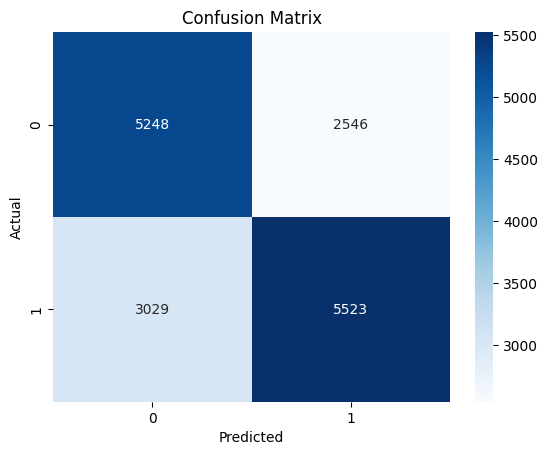

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
len(y_true_all)

16346

In [24]:
len(y_pred_all)

16346

In [30]:
y_true_all[1:10]

[0, 0, 0, 1, 1, 0, 0, 1, 0]

In [29]:
y_pred_all[1:10]

[0, 0, 0, 1, 1, 0, 0, 1, 0]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

K_values = [5, 10, 20, 50, 100, 150, 255]
precision_scores = []
recall_scores = []

for K in K_values:
    y_true_all = []
    y_pred_all = []

    for index, row in test_ratings.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        y_true_all.append(row['rating'])

        # Get k nearest neighbors based on item-item similarity
        nearest_neighbors = get_k_nearest_neighbors(item_similarity_df, movie_id, k=K)

        # Get the ratings of the user for the nearest neighbors
        neighbor_ratings = user_item_matrix.loc[user_id, nearest_neighbors]

        # If there are no ratings by nearest neighbors, predict 0
        if neighbor_ratings.isna().all():
            y_pred_all.append(0)
        else:
            # Predict the rating based on the majority vote of neighbor ratings
            y_pred_all.append(Counter(neighbor_ratings.dropna()).most_common(1)[0][0])

    # Convert to integers
    y_true_all = [int(val) for val in y_true_all]
    y_pred_all = [int(val) for val in y_pred_all]

    precision = precision_score(y_true_all, y_pred_all, average='binary')
    recall = recall_score(y_true_all, y_pred_all, average='binary')

    precision_scores.append(precision)
    recall_scores.append(recall)

# Plotting the precision and recall scores
plt.figure(figsize=(10, 6))
plt.plot(K_values, precision_scores, label='Precision@K')
plt.plot(K_values, recall_scores, label='Recall@K')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Precision and Recall at K')
plt.legend()
plt.grid(True)
plt.show()
